#  Nearest Neighbor Methods Introduction

We will cover all this topics

* Working with Nearest Neighbors

* Working with Text-Based Distances

* Computing Mixed Distance Functions

* Using an Address Matching Example

![KNN](img/1.knn.jpg)

Nearest neighbor methods are based on a distance-based conceptual idea. We consider our training set as the model and make predictions on new points based on how close they are to points in the training set. A naïve way is to make the prediction as the closest training data point class. But since most datasets contain a degree of noise, a more common method would be to take a weighted average of a set of k nearest neighbors. This method is called k-nearest neighbors (k-NN).

Given a training dataset (x1, x2, ..., xn), with corresponding targets (y1, y2, ..., yn), we can make a prediction on a point, z, by looking at a set of nearest neighbors. The actual method of prediction depends on whether or not we are doing regression (continuous y) or classification (discrete y).

For discrete classification targets, the prediction may be given by a maximum voting scheme weighted by the distance to the prediction point:

prediction(z) = max ( weighted sum of distances of points in each class )

Here, our prediction is the maximum weighted value over all classes (j), where the weighted distance from the prediction point is usually given by the L1 or L2 distance functions.

Continuous targets are very similar, but we usually just compute a weighted average of the target variable (y) by distance.

There are many different specifications of distance metrics that we can choose. In this chapter, we will explore the L1 and L2 metrics as well as edit and textual distances.

We also have to choose how to weight the distances. A straight forward way to weight the distances is by the distance itself. Points that are further away from our prediction should have less impact than nearer points. The most common way to weight is by the normalized inverse of the distance. We will implement this method in the next recipe.

Note that k-NN is an aggregating method. For regression, we are performing a weighted average of neighbors. Because of this, predictions will be less extreme and less varied than the actual targets. The magnitude of this effect will be determined by k, the number of neighbors in the algorithm.

# Working

We will use the 1970s Boston housing dataset which is available through the UCI ML data repository.

***Data:***
----------x-values-----------

* CRIM : per capita crime rate by town
* ZN : prop. of res. land zones
* INDUS : prop. of non-retail business acres
* CHAS : Charles river dummy variable
* NOX : nitrix oxides concentration / 10 M
* RM : Avg. # of rooms per building
* AGE : prop. of buildings built prior to 1940
* DIS : Weighted distances to employment centers
* RAD : Index of radian highway access
* TAX : Full tax rate value per $10k
* PTRATIO: Pupil/Teacher ratio by town
* B : 1000*(Bk-0.63)^2, Bk=prop. of blacks
* LSTAT : % lower status of pop


------------y-value-----------

* MEDV : Median Value of homes in $1,000's

In [2]:
# import required libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
sess = tf.Session()

In [4]:
#Load the data

housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

## Min-Max Scaling
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

In [5]:
#Split the data into train and test sets

np.random.seed(13)  #make results reproducible
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [6]:
# Declare k-value and batch size
k = 4
batch_size=len(x_vals_test)

# Placeholders
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)


# Declare distance metric

***L1 Distance Metric***


Uncomment following line and comment L2

In [7]:
#distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), axis=2)

In [8]:
distance

<tf.Tensor 'Sum:0' shape=(?, ?) dtype=float32>

*** L2 Distance Metric ***

Uncomment following line and comment L1 above

In [9]:
distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), reduction_indices=1))

# Predict: Get min distance index (Nearest neighbor)

In [10]:
#prediction = tf.arg_min(distance, 0)
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals), axis=[1])
#prediction = tf.reduce_mean(top_k_yvals, 1)

# Calculate MSE
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

# Calculate how many loops over training data
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})

    print('Batch #' + str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))

Batch #1 MSE: 105.378


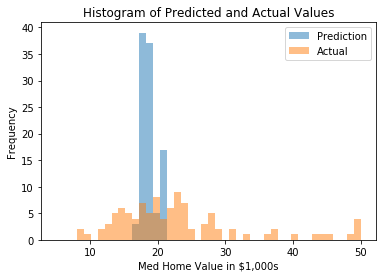

In [14]:

%matplotlib  inline
# Plot prediction and actual distribution
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()